In [ ]:
#|default_exp geospatial.sentinel

In [ ]:
#| export
from __future__ import annotations

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from typing import Callable
from dataclasses import dataclass
from fastai.vision.all import *

from fastai_geospatial.vision.core import *

# Support for Sentinel-2 Data

Sentinel 2 images consist of 13 raw bands, with pixel resolution ranging from 10m to 20m to 60m. In practice, we may be working with a subset of these bands.

For example we may choose to only work with the 10m resolution bands IR, R, G, B with corresponding band ids "B08", "B04", "B03", "B02". 

If we create an input tensor of such images the tensor indices of the image data for each band will be 0, 1, 2, 3 (for dimension 0) respectively.

## `BandInputs` support class

To do this we need a helper class that maps channel names to channel indexes.

In [ ]:
#| exports
@dataclass
class BandInputs:
    ids: list[str]
    idxs: list[int]

    @classmethod
    def from_ids(cls, ids: list[str]):
        return cls(ids, [i for i in range(len(ids))])

Map the the channels "B01", "B02", "B03" to 0, 1, 2

In [ ]:
bands = BandInputs.from_ids(["B01","B02","B03"])

test_eq(bands, BandInputs(ids=["B01","B02","B03"], idxs=[0,1,2]))

The following method returns the index corresponding to a channel name

In [ ]:
#| export
@patch
def _get_index(self: BandInputs, id: str) -> int:
    return self.idxs[self.ids.index(id)]

In [ ]:
test_eq(bands._get_index("B02"), 1)

Return index tuples corresponding to a list of channel names.

In [ ]:
#| export
@patch
def _get_bands(self: BandInputs, ids: list[str]) -> tuple[int]:
    assert set(ids).issubset(set(self.ids))
    return tuple(self._get_index(id) for id in ids)

In [ ]:
test_eq(bands._get_bands(["B03","B01"]), (2, 0))

Return list of index tuples corresponding to a list of lists of index channel names.

In [ ]:
#| export
@patch
def get_bands_list(self: BandInputs, ids_list: list[list[str]]) -> list[tuple[int]]:
    return [self._get_bands(ids) for ids in ids_list]

In [ ]:
test_eq(
    bands.get_bands_list([["B03","B02","B01"], ["B01"], ["B03"]]),
    [(2, 1, 0), (0,), (2,)],
)

## `Sentinel2` tensor loader

We need a class that can load tensors corresponding to sub-sets of sentinel channels.

We begin an enumeration of the names of all possible channels and associated information. One such item of information, is the resolution corresponding to each channel.

Another piece of information is a list of the `brgtX` "brightening" multipliers for each channel (as described [here](07a_vision.core.ipynb#Image-Brightening)). We have selected values that seem to work well with our data, but it is by no means an authoritative list.

We have also provide some named groups of 3 bands each, that have been found useful in providing [false color images for different applications](https://gisgeography.com/sentinel-2-bands-combinations/). The goal is to create (multiple) RGB images, corresponding to such sets of bands, for each multi-spectral tensor.

In [ ]:
#| export
class Sentinel2:
    band_ids: list[str] = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12","AOT",]
    res_m: list[int] = [60,10,10,10,20,20,20,10,20,60,60,20,20,20]
    brgtX: list[float] = [2.5,4.75,4.25,3.75,3,2,1.7,1.7,2.5,2.5,1.6,1.6,2.2,30,]

    # https://gisgeography.com/sentinel-2-bands-combinations/
    natural_color = ["B04","B03","B02"]
    color_infrared = ["B08","B04","B03"]
    short_wave_infrared = ["B12","B8a","B04"]
    agriculture = ["B11","B08","B02"]
    geology = ["B12","B11","B02"]
    bathymetric = ["B04","B03","B01"]

This method lists all bands of a given resolution.

In [ ]:
#| export
@patch(cls_method=True)
def get_res_ids(cls: Sentinel2, res: int) -> list[str]:
    indices = [i for i,r in enumerate(cls.res_m) if r == res]
    return [cls.band_ids[i] for i in indices]

In [ ]:
test_eq(Sentinel2.get_res_ids(10),["B02","B03","B04","B08"])

We can find the brightness multipliers corresponding to a list of channel names with this

In [ ]:
#| export
@patch(cls_method=True)
def get_brgtX(cls: Sentinel2, ids: list[str]) -> list[float]:
    indices = [cls.band_ids.index(id) for id in ids]
    return [cls.brgtX[i] for i in indices]

In [ ]:
test_eq(Sentinel2.get_brgtX(["B8A","B01"]), [2.5,2.5])
test_eq(Sentinel2.get_brgtX(Sentinel2.natural_color), [3.75,4.25,4.75])

... and so also the brightness value lists corresponding to name lists

In [ ]:
#| export
@patch(cls_method=True)
def get_brgtX_list(cls: Sentinel2, ids_list: list[list[str]]) -> list[list[float]]:
    return [cls.get_brgtX(ids) for ids in ids_list]

In [ ]:
test_eq(
    Sentinel2.get_brgtX_list([Sentinel2.color_infrared,["B12","B11"]]), 
    [[1.7,3.75,4.25],[2.2,1.6]]
)

The actual constructor of Sentinel 2 objects takes parameters that specifices how to load the multi spectral image into a `TensorImageMS` object.

In [ ]:
#| export
@patch
def __init__(
    self: Sentinel2,
    band_ids: list[str],
    chn_grp_ids: list[list[str]],
    files_getter: Callable[[list[str], Any], list[str]],
    chan_io_fn: Callable[[list[str]], Tensor],
):
    self.bands = BandInputs.from_ids(band_ids)
    self.chn_grp_ids = chn_grp_ids
    self.files_getter = files_getter
    self.chan_io_fn = chan_io_fn

In [ ]:
from fastai_geospatial.vision.io import *

In our case, the callable is `get_channel_filenames` [from here](00_vision.io.ipynb#File-paths-and-names)

We can create a sentinel data loader for only the RGB channels

In [ ]:
rgb_bands = Sentinel2(
    ["B02","B03","B04"],
    [Sentinel2.natural_color],
    get_channel_filenames,
    read_multichan_files_as_tensor
)

or we might choose to only look at the 10m resolution bands 

In [ ]:
tenm_bands = Sentinel2(
    Sentinel2.get_res_ids(10),
    [Sentinel2.natural_color, ["B08"]],
    get_channel_filenames,
    read_multichan_files_as_tensor
)

In [ ]:
#| export
@patch
def _load_tensor(self: Sentinel2, img_id, cls: TensorImage) -> TensorImage:
    files = self.files_getter(self.bands.ids, img_id)
    ids_list = self.chn_grp_ids
    bands = self.bands.get_bands_list(ids_list)
    brgtX = self.__class__.get_brgtX_list(ids_list)
    return cls(self.chan_io_fn(files), bands=bands, brgtX=brgtX)

@patch
def load_tensor(self: Sentinel2, img_id) -> TensorImageMS:
    return self._load_tensor(img_id, TensorImageMS)                

[<AxesSubplot: >]

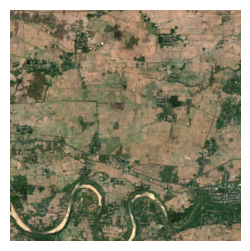

In [ ]:
rgb_tensor = rgb_bands.load_tensor(66)
rgb_tensor.show()

[<AxesSubplot: >, <AxesSubplot: >]

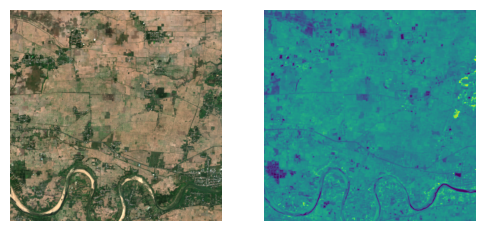

In [ ]:
tenm_tensor = tenm_bands.load_tensor(66)
tenm_tensor.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()